Esta notebook contiene bloques de código útiles para realizar Q-learning en el entorno "Descent Env"

In [1]:
import numpy as np
from descent_env import DescentEnv
import random 
from q_learning_agent import QLearningAgent

pygame 2.5.2 (SDL 2.28.3, Python 3.10.8)
Hello from the pygame community. https://www.pygame.org/contribute.html
Using Python-based geo functions


In [2]:
# Cambiar render_mode a rgb_array para entrenar/testear
from env_recorder_wrapper import VideoRecorderWrapper 
import wandb
env = DescentEnv(render_mode='rgb_array')

Reading config from /Users/agustinvarela/bluesky/settings.cfg
Reading magnetic variation data
Loading global navigation database...
Reading cache: /Users/agustinvarela/bluesky/cache/navdata.p
Successfully loaded OpenAP performance model
Failed to load BADA performance model
Successfully loaded legacy performance model
Successfully loaded plugin AREA
Successfully loaded plugin DATAFEED


Observation Space

In [3]:
env.observation_space

Dict('altitude': Box(-inf, inf, (1,), float64), 'runway_distance': Box(-inf, inf, (1,), float64), 'target_altitude': Box(-inf, inf, (1,), float64), 'vz': Box(-inf, inf, (1,), float64))

Action Space

In [4]:
env.action_space

Box(-1.0, 1.0, (1,), float64)

Discretización de los estados

**Nota:** es importante que chequeen el espacio de observación y el espacio de acción del entorno. Los números usados son ejemplos y pueden no ser correctos

In [5]:
altitude_space_start = 0
altitude_space_end = 2.5
altitude_space_num = 15
altitude_space = np.linspace(altitude_space_start, altitude_space_end, altitude_space_num) 

vertical_velocity_space_start = -3
vertical_velocity_space_end = 3
vertical_velocity_space_num = 20
vertical_velocity_space = np.linspace(vertical_velocity_space_start, vertical_velocity_space_end, vertical_velocity_space_num) 

target_altitude_space_start = 0
target_altitude_space_end = 1
target_altitude_space_num = 10
target_altitude_space = np.linspace(target_altitude_space_start, target_altitude_space_end, target_altitude_space_num)

runway_distance_space_start = -1
runway_distance_space_end = 1
runway_distance_space_num = 20
runway_distance_space = np.linspace(runway_distance_space_start, runway_distance_space_end, runway_distance_space_num)


#print("altitude_space:", altitude_space)
#print("vertical_velocity_space:", vertical_velocity_space)
#print("target_altitude_space:", target_altitude_space)
#print("runway_distance_space:", runway_distance_space)


#import gymnasium as gym
#from descent_env import DescentEnv
#import numpy as np
#import random
#
#env = DescentEnv(render_mode="human") 
#obs, info = env.reset()
#
#num_episodes = 5 
#max_steps_per_episode = 500 
#
#all_altitudes = []
#all_vertical_velocities = []
#all_target_altitudes = []
#all_runway_distances = []
#
#for episode in range(num_episodes):
#    obs, info = env.reset()
#    done = False
#    steps = 0
#    print(f"\n--- Episodio {episode + 1} ---")
#    while not done and steps < max_steps_per_episode:
#        # Aquí generas una acción aleatoria válida para tu entorno
#        actions = [-1.0, -0.5, 0.0, 0.5, 1.0] # Acciones discretas sugeridas en el notebook
#        action = np.array([random.choice(actions)])
#
#        obs, reward, done, truncated, info = env.step(action)
#
#        # Recolectar datos
#        all_altitudes.append(obs["altitude"][0])
#        all_vertical_velocities.append(obs["vz"][0])
#        all_target_altitudes.append(obs["target_altitude"][0])
#        all_runway_distances.append(obs["runway_distance"][0])
#        steps += 1
#        
#    env.render()
#    env.close()
#
## Analizar los datos recolectados
#print("\n--- Análisis de rangos observados ---")
#print(f"Altitud: Min={np.min(all_altitudes):.2f}, Max={np.max(all_altitudes):.2f}")
#print(f"Velocidad Vertical: Min={np.min(all_vertical_velocities):.2f}, Max={np.max(all_vertical_velocities):.2f}")
#print(f"Altitud Objetivo: Min={np.min(all_target_altitudes):.2f}, Max={np.max(all_target_altitudes):.2f}")
#print(f"Distancia Pista: Min={np.min(all_runway_distances):.2f}, Max={np.max(all_runway_distances):.2f}")
#"""

In [6]:
actions = list(np.linspace(-1, 1, 10))
agent = QLearningAgent(
    altitude_space, 
    vertical_velocity_space, 
    target_altitude_space,
    runway_distance_space,  
    actions=actions,
    env=env
)

In [7]:
episodes = 6000
epsilon = 0.99
gamma = 0.5
alpha = 0.5
rewards = agent.train_agent(env=env, episodes=episodes, epsilon=epsilon, gamma=gamma, alpha=alpha)

Episode: 0, Reward: -120.60, Epsilon: 0.99
Episode: 1, Reward: -96.48, Epsilon: 0.99
Episode: 2, Reward: -87.06, Epsilon: 0.99
Episode: 3, Reward: -143.53, Epsilon: 0.99
Episode: 4, Reward: -123.89, Epsilon: 0.99
Episode: 5, Reward: -181.69, Epsilon: 0.99
Episode: 6, Reward: -54.82, Epsilon: 0.99
Episode: 7, Reward: -68.82, Epsilon: 0.99
Episode: 8, Reward: -72.88, Epsilon: 0.99
Episode: 9, Reward: -68.42, Epsilon: 0.99
Episode: 10, Reward: -81.09, Epsilon: 0.99
Episode: 11, Reward: -99.06, Epsilon: 0.99
Episode: 12, Reward: -146.02, Epsilon: 0.99
Episode: 13, Reward: -177.47, Epsilon: 0.99
Episode: 14, Reward: -81.72, Epsilon: 0.99
Episode: 15, Reward: -182.76, Epsilon: 0.99
Episode: 16, Reward: -76.50, Epsilon: 0.99
Episode: 17, Reward: -128.05, Epsilon: 0.98
Episode: 18, Reward: -192.33, Epsilon: 0.98
Episode: 19, Reward: -162.29, Epsilon: 0.98
Episode: 20, Reward: -139.24, Epsilon: 0.98
Episode: 21, Reward: -58.11, Epsilon: 0.98
Episode: 22, Reward: -83.62, Epsilon: 0.98
Episode: 2

Obtener el estado a partir de la observación

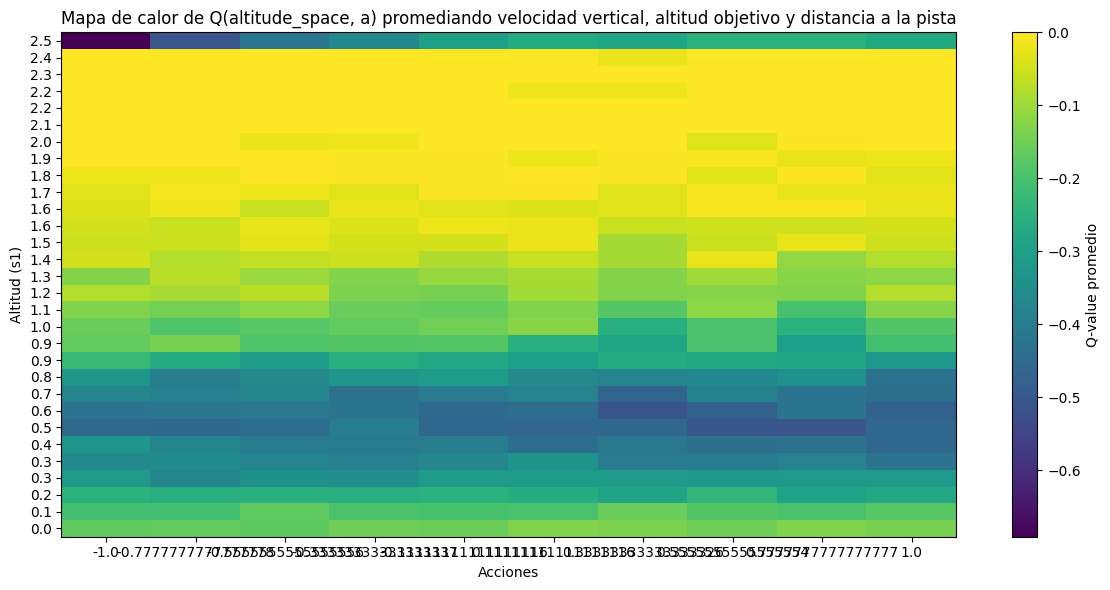

TypeError: plot_q_mean_heatmap() missing 4 required positional arguments: 'heatmap', 's1_space', 'action_values', and 'title'

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_q_mean_heatmap(q_table, action_values, s1_space, s2_space, s3_space, s4_space):
    """
    Calcula un mapa de calor de Q(s1, a) promediado sobre s2, s3 y s4.

    Returns:
        np.ndarray: Matriz de tamaño (len(s1_space), len(action_values)) con los valores promedios.
    """
    heatmap = np.zeros((len(s1_space), len(action_values)))

    for s1_index in range(len(s1_space)):
        for action_index in range(len(action_values)):
            q_sum = 0
            count = 0
            for s2_index in range(len(s2_space)):
                for s3_index in range(len(s3_space)):
                    for s4_index in range(len(s4_space)):
                        q_sum += q_table[s1_index, s2_index, s3_index, s4_index, action_index]
                        count += 1
            heatmap[s1_index, action_index] = q_sum / count

    return heatmap

def plot_q_mean_heatmap(heatmap, s1_space, action_values, title):
    """
    Grafica un mapa de calor para Q(s1, a) promedio.

    Args:
        heatmap (np.ndarray): Matriz (s1, a) con valores promedio.
    """
    plt.figure(figsize=(12, 6))
    im = plt.imshow(heatmap, aspect='auto', cmap='viridis', origin='lower')

    plt.colorbar(im, label="Q-value promedio")
    plt.xlabel("Acciones")
    plt.ylabel("Altitud (s1)")
    plt.title(title)
    plt.xticks(ticks=np.arange(len(action_values)), labels=[str(a) for a in action_values])
    plt.yticks(ticks=np.arange(len(s1_space)), labels=[f"{v:.1f}" for v in s1_space])
    plt.tight_layout()
    plt.show()

heatmap = calculate_q_mean_heatmap(
    q_table=agent.q,
    action_values=actions,
    s1_space=altitude_space,
    s2_space=vertical_velocity_space,
    s3_space=target_altitude_space,
    s4_space=runway_distance_space
)

plot_q_mean_heatmap(
    heatmap=heatmap,
    s1_space=altitude_space,
    action_values=actions,
    title="Mapa de calor de Q(altitude_space, a) promediando velocidad vertical, altitud objetivo y distancia a la pista"
)

plot_q_mean_heatmap(
    
)

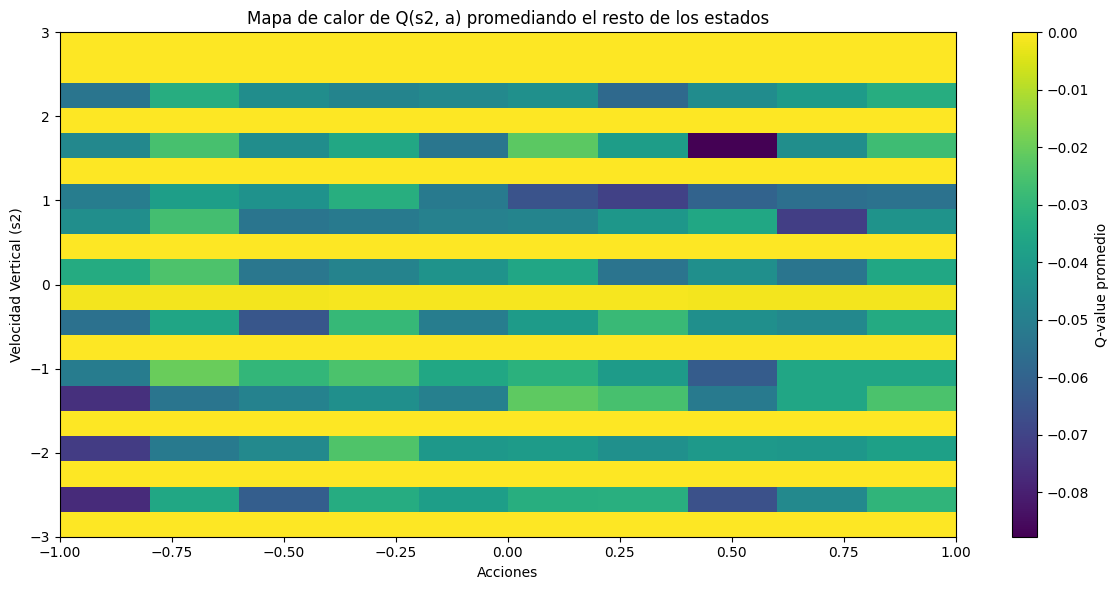

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_q_mean_heatmap_general(q_table, action_values, state_spaces, target_dim):
    """
    Calcula un mapa de calor de Q(s, a) promediado sobre las demás dimensiones.

    Args:
        q_table (np.ndarray): La tabla Q.
        action_values (list): Lista de valores de las acciones.
        state_spaces (list): Lista de espacios discretizados para cada dimensión (s1, s2, s3, s4).
        target_dim (int): Índice de la dimensión principal (0 para s1, 1 para s2, etc.).

    Returns:
        np.ndarray: Matriz de tamaño (len(state_spaces[target_dim]), len(action_values)) con los valores promedios.
    """
    # Crear un heatmap vacío
    heatmap = np.zeros((len(state_spaces[target_dim]), len(action_values)))

    # Identificar las dimensiones a promediar
    other_dims = [i for i in range(len(state_spaces)) if i != target_dim]

    # Iterar sobre la dimensión principal (target_dim)
    for target_index in range(len(state_spaces[target_dim])):
        for action_index in range(len(action_values)):
            q_sum = 0
            count = 0

            # Iterar sobre las demás dimensiones
            for indices in np.ndindex(*[len(state_spaces[dim]) for dim in other_dims]):
                # Construir el índice completo para acceder a q_table
                full_index = [0] * len(state_spaces)
                full_index[target_dim] = target_index
                for i, dim in enumerate(other_dims):
                    full_index[dim] = indices[i]
                full_index.append(action_index)  # Agregar el índice de la acción

                # Sumar el valor Q
                q_sum += q_table[tuple(full_index)]
                count += 1

            # Calcular el promedio para la acción actual
            heatmap[target_index, action_index] = q_sum / count

    return heatmap

def plot_q_mean_heatmap_general(heatmap, state_space, action_values, state_label, title):
    """
    Grafica un mapa de calor para Q(s, a) promedio.

    Args:
        heatmap (np.ndarray): Matriz (s, a) con valores promedio.
        state_space (list): Valores discretizados para la dimensión principal.
        action_values (list): Lista de valores de las acciones.
        state_label (str): Etiqueta para la dimensión principal (e.g., "Altitud", "Velocidad Vertical").
        title (str): Título del gráfico.
    """
    plt.figure(figsize=(12, 6))
    im = plt.imshow(heatmap, aspect='auto', cmap='viridis', origin='lower',
                    extent=[action_values[0], action_values[-1], state_space[0], state_space[-1]])

    plt.colorbar(im, label="Q-value promedio")
    plt.xlabel("Acciones")
    plt.ylabel(state_label)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Ejemplo de uso generalizado
state_spaces = [altitude_space, vertical_velocity_space, target_altitude_space, runway_distance_space]

# Calcular el heatmap para una dimensión específica (por ejemplo, s2: velocidad vertical)
target_dim = 1  # Índice de la dimensión principal (0: s1, 1: s2, 2: s3, 3: s4)
heatmap_general = calculate_q_mean_heatmap_general(
    q_table=agent.q,
    action_values=actions,
    state_spaces=state_spaces,
    target_dim=target_dim
)

# Graficar el heatmap
plot_q_mean_heatmap_general(
    heatmap=heatmap_general,
    state_space=state_spaces[target_dim],
    action_values=actions,
    state_label="Velocidad Vertical (s2)",  # Cambiar según la dimensión
    title="Mapa de calor de Q(s2, a) promediando el resto de los estados"
)

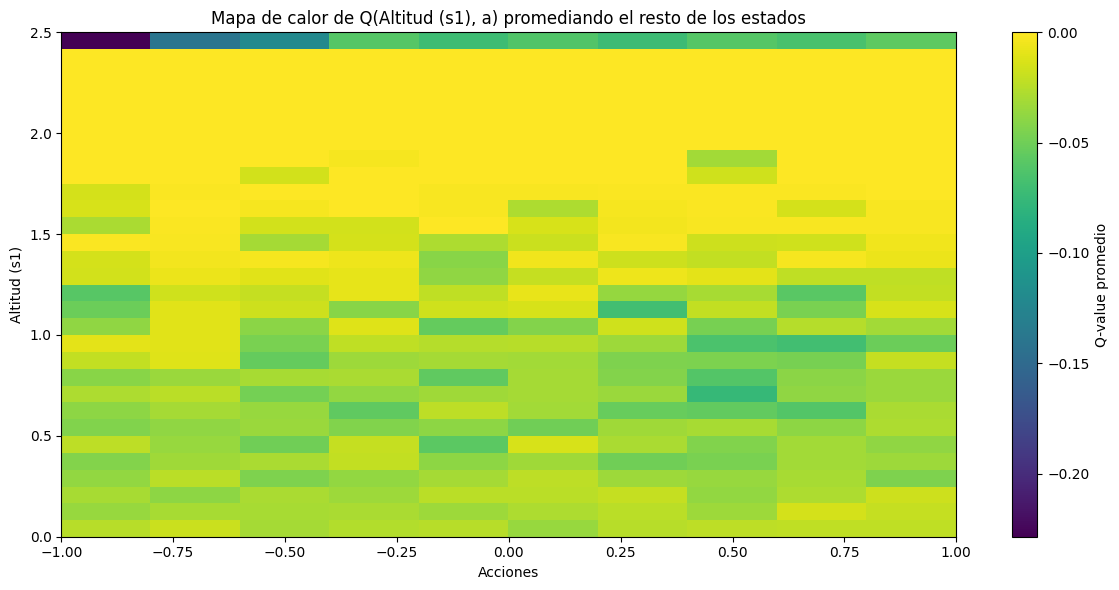

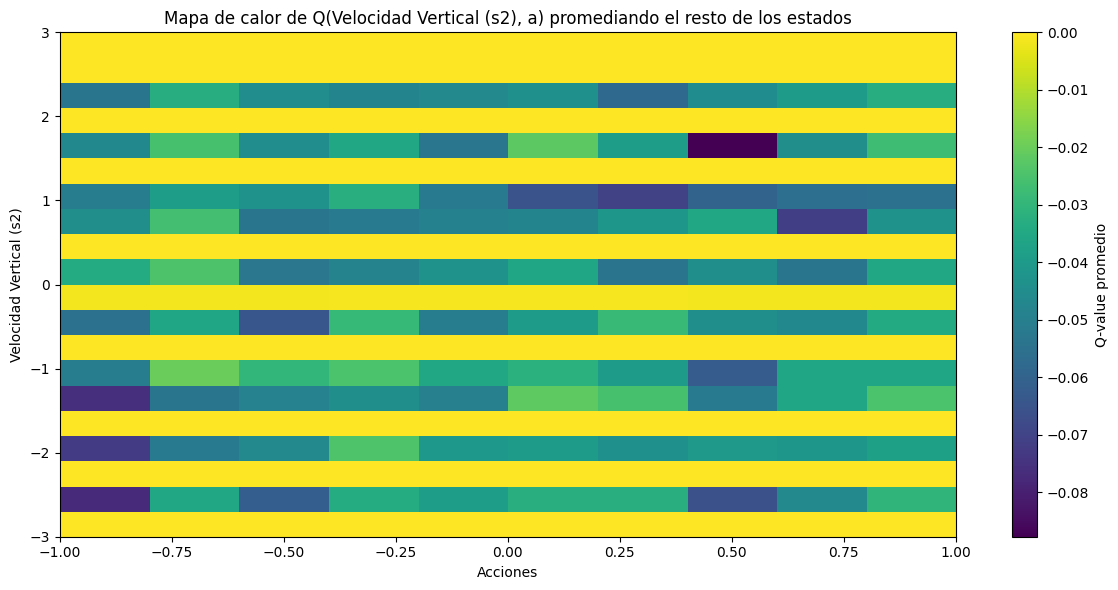

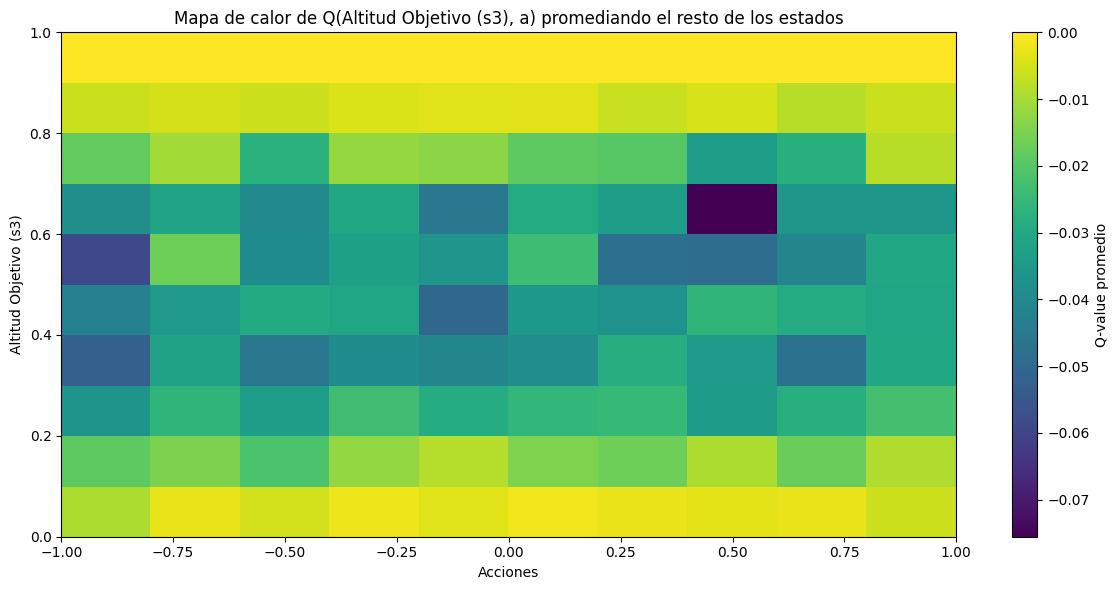

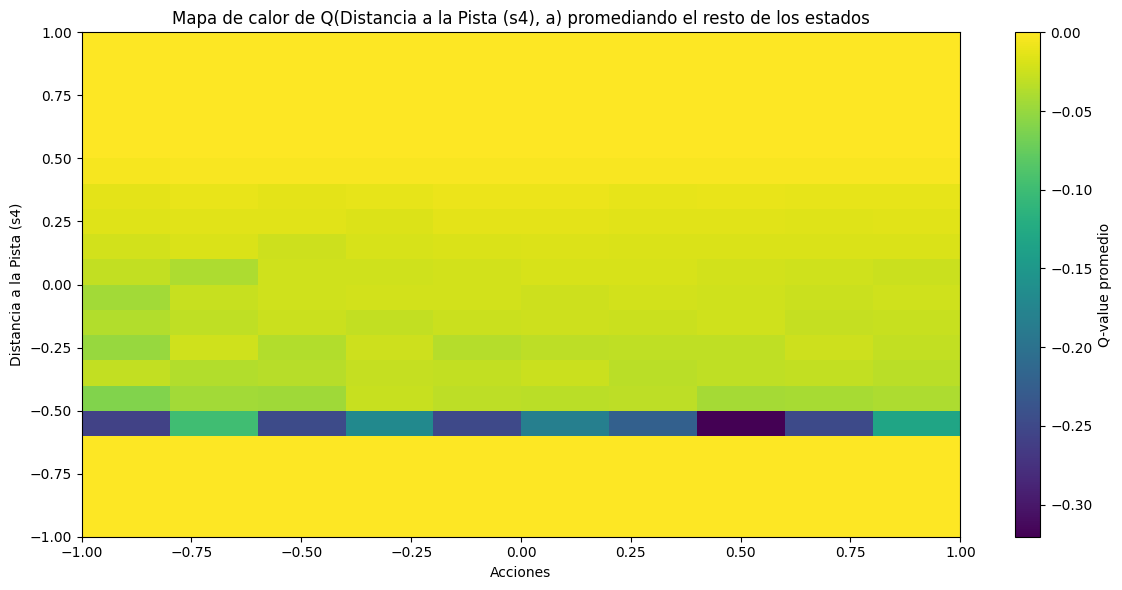

In [ ]:
# Graficar mapas de calor para todas las dimensiones
dimensions = ["Altitud (s1)", "Velocidad Vertical (s2)", "Altitud Objetivo (s3)", "Distancia a la Pista (s4)"]

for target_dim, dimension_label in enumerate(dimensions):
    # Calcular el heatmap para la dimensión actual
    heatmap = calculate_q_mean_heatmap_general(
        q_table=agent.q,
        action_values=actions,
        state_spaces=[altitude_space, vertical_velocity_space, target_altitude_space, runway_distance_space],
        target_dim=target_dim
    )

    # Graficar el heatmap
    plot_q_mean_heatmap_general(
        heatmap=heatmap,
        state_space=[altitude_space, vertical_velocity_space, target_altitude_space, runway_distance_space][target_dim],
        action_values=actions,
        state_label=dimension_label,
        title=f"Mapa de calor de Q({dimension_label}, a) promediando el resto de los estados"
    )

In [ ]:
average_reward = np.mean(rewards)
print(f"Promedio de recompensas: {average_reward}")

Promedio de recompensas: -106.80346609125002


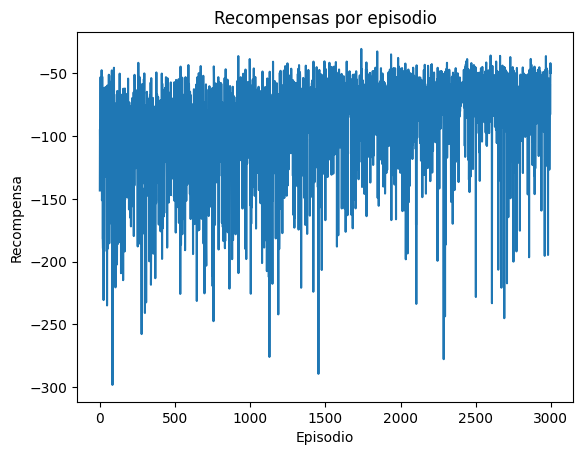

In [9]:
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.xlabel('Episodio')
plt.ylabel('Recompensa')
plt.title('Recompensas por episodio')
plt.show()

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Proyectar la tabla Q en una dimensión (por ejemplo, altitud)
def plot_q_table_heatmap(q_table, dimension, dimension_values, title):
    # Calcular el promedio de Q sobre las demás dimensiones
    q_projection = q_table.mean(axis=tuple(i for i in range(q_table.ndim) if i != dimension))

    # Crear el mapa de calor
    plt.figure(figsize=(10, 6))
    sns.heatmap(q_projection.reshape(-1, 1), annot=False, cmap="coolwarm", cbar=True, yticklabels=dimension_values)
    plt.title(title)
    plt.xlabel("Q-value")
    plt.ylabel("Dimension Values")
    plt.show()

# Ejemplo: Visualizar los hotspots de la tabla Q para la dimensión de altitud
plot_q_table_heatmap(agent.q_table, dimension=0, dimension_values=altitude_space, title="Hotspots de Q-Table para Altitud")

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
test_rewards = agent.test_agent(env, episodes=500)
test_average_reward = np.mean(test_rewards)
print(f"Promedio de recompensas en test: {test_average_reward}")


Episode: 0, Reward: -41.50
Episode: 1, Reward: -75.42
Episode: 1, Reward: -75.42
Episode: 2, Reward: -59.70
Episode: 2, Reward: -59.70
Episode: 3, Reward: -49.78
Episode: 3, Reward: -49.78
Episode: 4, Reward: -40.01
Episode: 4, Reward: -40.01
Episode: 5, Reward: -61.02
Episode: 5, Reward: -61.02
Episode: 6, Reward: -61.74
Episode: 6, Reward: -61.74
Episode: 7, Reward: -43.84
Episode: 7, Reward: -43.84
Episode: 8, Reward: -111.10
Episode: 8, Reward: -111.10
Episode: 9, Reward: -60.57
Episode: 9, Reward: -60.57
Episode: 10, Reward: -111.81
Episode: 10, Reward: -111.81
Episode: 11, Reward: -114.22
Episode: 11, Reward: -114.22
Episode: 12, Reward: -135.48
Episode: 12, Reward: -135.48
Episode: 13, Reward: -61.71
Episode: 13, Reward: -61.71
Episode: 14, Reward: -58.36
Episode: 14, Reward: -58.36
Episode: 15, Reward: -62.29
Episode: 16, Reward: -112.17
Episode: 15, Reward: -62.29
Episode: 16, Reward: -112.17
Episode: 17, Reward: -55.41
Episode: 17, Reward: -55.41
Episode: 18, Reward: -61.83
E

In [12]:
# Configuración de wandb
wandb.login(key="b1666b9050a5ade20a5130837a3c3c5ac2e39580")
wandb.init(project="descent_env_training", name="training_run")
# Guardar hiperparámetros
wandb.config.update({
    "epsilon": epsilon,
    "gamma": gamma,
    "alpha": alpha,
    "episodes": episodes,
    "altitude_space_start": altitude_space_start,
    "altitude_space_end": altitude_space_end,
    "altitude_space_num": altitude_space_num,
    "vertical_velocity_space_start": vertical_velocity_space_start,
    "vertical_velocity_space_end": vertical_velocity_space_end,
    "vertical_velocity_space_num": vertical_velocity_space_num,
    "target_altitude_space_start": target_altitude_space_start,
    "target_altitude_space_end": target_altitude_space_end,
    "target_altitude_space_num": target_altitude_space_num,
    "runway_distance_space_start": runway_distance_space_start,
    "runway_distance_space_end": runway_distance_space_end,
    "runway_distance_space_num": runway_distance_space_num
})

# Guardar discretización de los datos
wandb.log({
    "test_average_reward": test_average_reward
})
wandb.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/agustinvarela/.netrc
wandb: Appending key for api.wandb.ai to your netrc file: /Users/agustinvarela/.netrc
wandb: Currently logged in as: agustinvarela2606 (artificial-inteligence-ort) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: agustinvarela2606 (artificial-inteligence-ort) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/agustinvarela/.netrc
wandb: Appending key for api.wandb.ai to your netrc file: /Users/agustinvarela/.netrc
wandb: Currently logged in as: agustinvarela2606 (artificial-inteligence-ort) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: agustinvarela2606 (artificial-inteligence-ort) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/agustinvarela/.netrc
wandb: Appending key for api.wandb.ai to your netrc file: /Users/agustinvarela/.netrc
wandb: Currently logged in as: agustinvarela2606 (artificial-inteligence-ort) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: agustinvarela2606 (artificial-inteligence-ort) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/agustinvarela/.netrc
wandb: Appending key for api.wandb.ai to your netrc file: /Users/agustinvarela/.netrc
wandb: Currently logged in as: agustinvarela2606 (artificial-inteligence-ort) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: agustinvarela2606 (artificial-inteligence-ort) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


test_average_reward,▁
test_average_reward,-69.897


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/agustinvarela/.netrc
wandb: Appending key for api.wandb.ai to your netrc file: /Users/agustinvarela/.netrc
wandb: Currently logged in as: agustinvarela2606 (artificial-inteligence-ort) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: agustinvarela2606 (artificial-inteligence-ort) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


test_average_reward,▁
test_average_reward,-69.897
